In [1]:
import os
import cv2
train_path = '/kaggle/input/trashcan/dataset/instance_version/train'
val_path = '/kaggle/input/trashcan/dataset/instance_version/val'

In [2]:
def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)  
            if img is not None:
                images.append(img)
    return images

In [3]:
train_images = load_images_from_directory(train_path)
val_images = load_images_from_directory(val_path)

print(f"Loaded {len(train_images)} training images and {len(val_images)} validation images.")

Loaded 6065 training images and 1147 validation images.


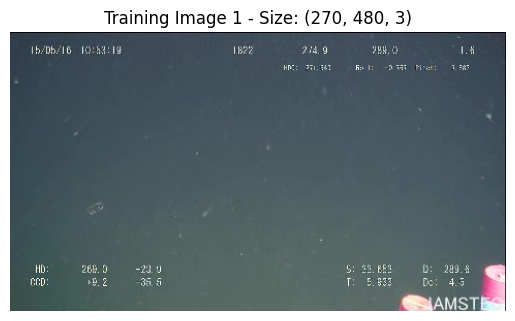

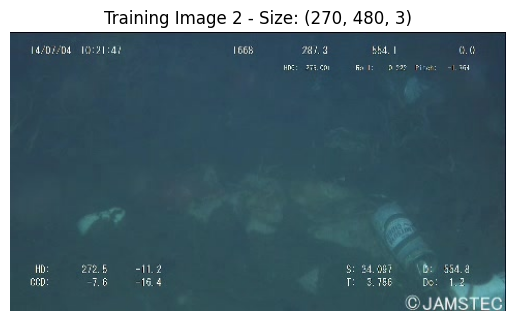

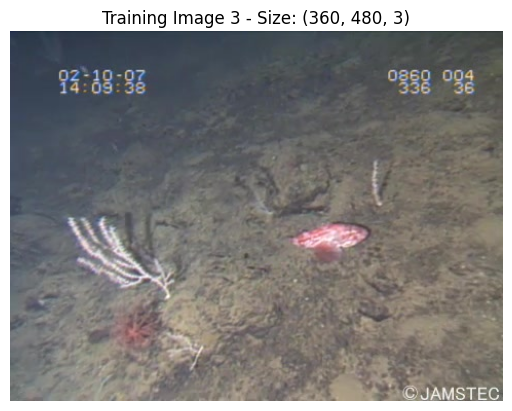

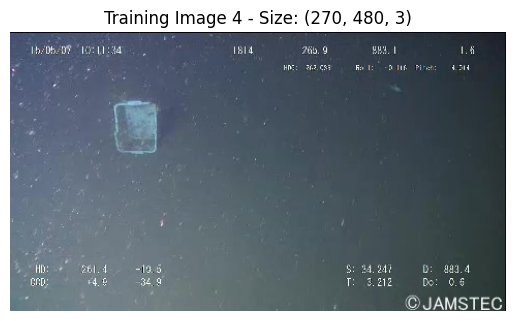

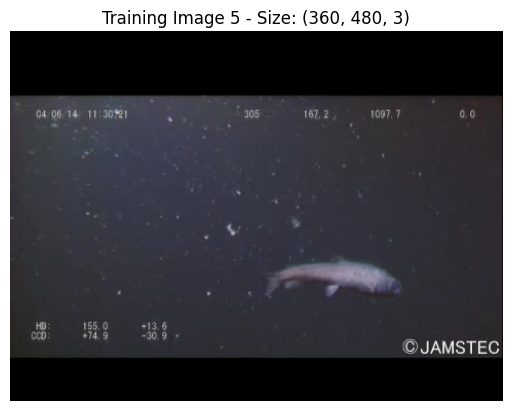

In [4]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure(i)
    plt.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Training Image {i+1} - Size: {train_images[i].shape}')
    plt.axis('off')
plt.show()

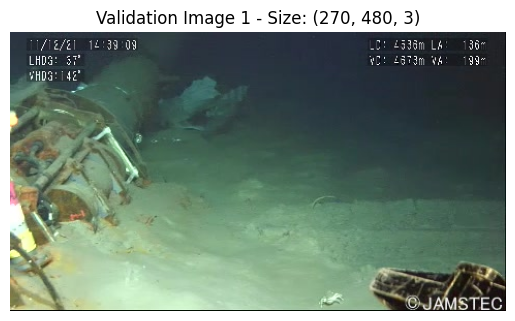

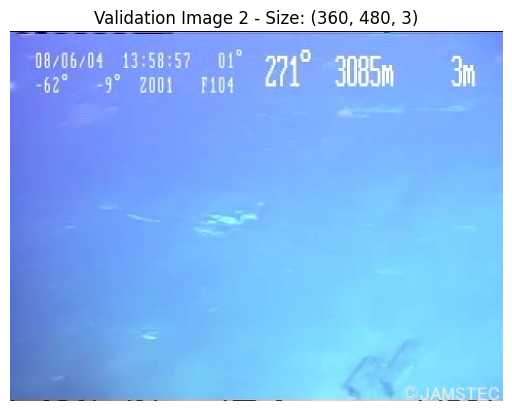

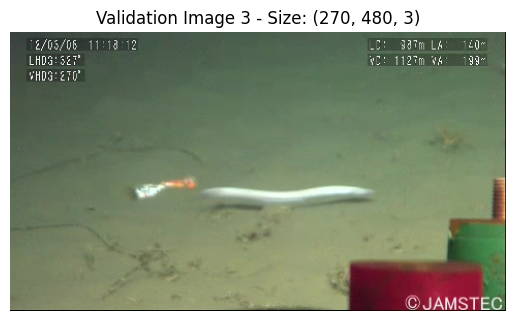

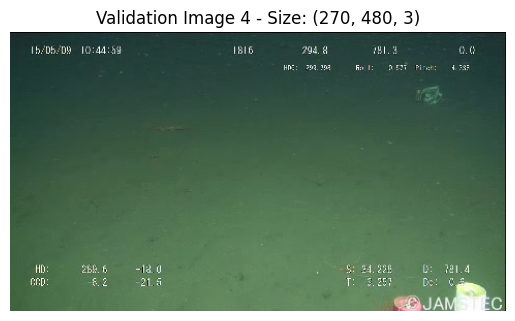

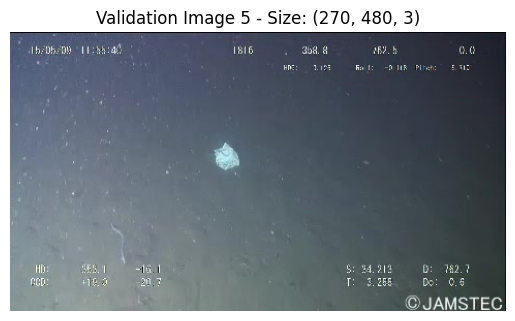

In [5]:
for i in range(5):
    plt.figure(i+5)
    plt.imshow(cv2.cvtColor(val_images[i], cv2.COLOR_BGR2RGB))
    plt.title(f'Validation Image {i+1} - Size: {val_images[i].shape}')
    plt.axis('off')
plt.show()

# Preprocessing images 

In [6]:
import os
import cv2
import pandas as pd
import numpy as np

train_path = '/kaggle/input/trashcan/dataset/instance_version/train'
val_path = '/kaggle/input/trashcan/dataset/instance_version/val'
output_folder = '/kaggle/working/all_images'

os.makedirs(output_folder, exist_ok=True)

filenames = []

In [7]:
def process_and_save_images(src_dir, output_dir, size=(640, 640)):
    for filename in os.listdir(src_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            src_path = os.path.join(src_dir, filename)
            unique_filename = filename  
            dest_path = os.path.join(output_dir, unique_filename)
            
            img = cv2.imread(src_path)
            if img is not None:
                img_resized = cv2.resize(img, size) 
                img_normalized = img_resized.astype(np.float32) / 255.0  
            
              
                cv2.imwrite(dest_path, (img_normalized * 255).astype(np.uint8))
                filenames.append(unique_filename)


In [8]:
# Process train and validation images
process_and_save_images(train_path, output_folder)
process_and_save_images(val_path, output_folder)

# Create a DataFrame to store filenames
df = pd.DataFrame(filenames, columns=['filename'])

# Save the filenames to a CSV file
csv_path = '/kaggle/working/all_images/filenames.csv'
df.to_csv(csv_path, index=False)

print(f"All images resized, normalized, and saved to '{output_folder}' and filenames saved to '{csv_path}'.")

All images resized, normalized, and saved to '/kaggle/working/all_images' and filenames saved to '/kaggle/working/all_images/filenames.csv'.


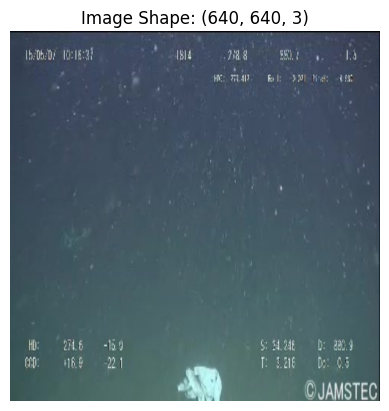

In [9]:
import matplotlib.pyplot as plt

image_path = '/kaggle/working/all_images/vid_000002_frame0000023.jpg' 
image = cv2.imread(image_path)
image_shape = image.shape 

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Image Shape: {image_shape}")
plt.axis('off')
plt.show()

In [10]:
import json
from tqdm import tqdm
def convert_coco_to_yolo(json_file, output_dir, image_size=(640, 640)):
    with open(json_file, 'r') as f:
        coco_data = json.load(f)

    # Create a dictionary to map category ids to numbers starting from 0
    categories = {cat['id']: idx for idx, cat in enumerate(coco_data['categories'])}

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create a dictionary to store image information
    image_info = {img['id']: img for img in coco_data['images']}

    # Group annotations by image
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)

    # Convert annotations for each image
    for image_id, annotations in tqdm(annotations_by_image.items(), desc="Converting annotations"):
        image = image_info[image_id]
        
        # Create a txt file for each image
        txt_filename = os.path.splitext(image['file_name'])[0] + '.txt'
        txt_path = os.path.join(output_dir, txt_filename)
        
        with open(txt_path, 'w') as f:
            for ann in annotations:
                # Get category id and map it to YOLO class number
                category_id = ann['category_id']
                yolo_class = categories[category_id]
                
                # Get bounding box coordinates
                x, y, w, h = ann['bbox']
                
                x_center = (x + w / 2) / image_size[0]
                y_center = (y + h / 2) / image_size[1]
                width = w / image_size[0]
                height = h / image_size[1]
                
                # Write to file
                f.write(f"{yolo_class} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    return len(annotations_by_image)

In [11]:
train_json = '/kaggle/input/trashcan/dataset/instance_version/instances_train_trashcan.json'
val_json = '/kaggle/input/trashcan/dataset/instance_version/instances_val_trashcan.json'

# Single output directory for all YOLO format annotations
yolo_output_dir = '/kaggle/working/yolo_annotations'

# Convert annotations
print("Converting train annotations...")
train_count = convert_coco_to_yolo(train_json, yolo_output_dir)
print(f"Processed {train_count} training images.")

print("Converting validation annotations...")
val_count = convert_coco_to_yolo(val_json, yolo_output_dir)
print(f"Processed {val_count} validation images.")

print(f"Conversion complete! All annotation files saved in {yolo_output_dir}")

Converting train annotations...


Converting annotations: 100%|██████████| 5936/5936 [00:00<00:00, 16764.70it/s]


Processed 5936 training images.
Converting validation annotations...


Converting annotations: 100%|██████████| 1147/1147 [00:00<00:00, 15895.60it/s]

Processed 1147 validation images.
Conversion complete! All annotation files saved in /kaggle/working/yolo_annotations


# Data Splitting

In [16]:
# from sklearn.model_selection import train_test_split

# csv_path = '/kaggle/working/all_images/filenames.csv'
# data = pd.read_csv(csv_path)

# train_data, temp_data = train_test_split(data, test_size=0.30, random_state=42)
# val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

# train_data.to_csv('/kaggle/working/train_filenames.csv', index=False)
# val_data.to_csv('/kaggle/working/val_filenames.csv', index=False)
# test_data.to_csv('/kaggle/working/test_filenames.csv', index=False)

# print("Data split successfully!")

Data split successfully!


In [12]:
from sklearn.model_selection import train_test_split
import shutil
image_dir = '/kaggle/working/all_images'
all_images = os.listdir(image_dir)


train_imgs, temp_imgs = train_test_split(all_images, test_size=0.30, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=42)


train_dir = '/kaggle/working/all_images/train'
val_dir = '/kaggle/working/all_images/val'
test_dir = '/kaggle/working/all_images/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for img in train_imgs:
    shutil.move(os.path.join(image_dir, img), train_dir)
for img in val_imgs:
    shutil.move(os.path.join(image_dir, img), val_dir)
for img in test_imgs:
    shutil.move(os.path.join(image_dir, img), test_dir)

print(f'Train: {len(train_imgs)}, Validation: {len(val_imgs)}, Test: {len(test_imgs)}')

Train: 5049, Validation: 1082, Test: 1082


# prepare data and annotation for yolo 

In [13]:
dataset_dir = '/kaggle/working/dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')


for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, split, 'labels'), exist_ok=True)

image_paths = {
    'train': '/kaggle/working/all_images/train',
    'val': '/kaggle/working/all_images/val',
    'test': '/kaggle/working/all_images/test'
}
annotation_dir = '/kaggle/working/yolo_annotations'

for split, img_dir in image_paths.items():
    img_dest_dir = os.path.join(dataset_dir, split, 'images')
    label_dest_dir = os.path.join(dataset_dir, split, 'labels')

    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
       
        annotation_name = img_name.replace('.jpg', '.txt')  

        annotation_path = os.path.join(annotation_dir, annotation_name)

        # Move image and its annotation
        if os.path.exists(annotation_path):
            shutil.move(img_path, img_dest_dir)
            shutil.move(annotation_path, label_dest_dir)
        else:
            print(f"Annotation not found for {img_name}")

print("Dataset restructured successfully!")


Annotation not found for vid_000365_frame0000019.jpg
Annotation not found for vid_000361_frame0000035.jpg
Annotation not found for vid_000128_frame0000018.jpg
Annotation not found for vid_000361_frame0000036.jpg
Annotation not found for vid_000363_frame0000014.jpg
Annotation not found for vid_000086_frame0000056.jpg
Annotation not found for vid_000347_frame0000023.jpg
Annotation not found for vid_000362_frame0000007.jpg
Annotation not found for vid_000362_frame0000009.jpg
Annotation not found for vid_000365_frame0000033.jpg
Annotation not found for vid_000347_frame0000021.jpg
Annotation not found for vid_000370_frame0000055.jpg
Annotation not found for vid_000253_frame0000001.jpg
Annotation not found for vid_000367_frame0000032.jpg
Annotation not found for vid_000365_frame0000012.jpg
Annotation not found for vid_000367_frame0000011.jpg
Annotation not found for vid_000361_frame0000017.jpg
Annotation not found for vid_000350_frame0000182.jpg
Annotation not found for vid_000251_frame00000

# Create YAML file

In [17]:
data_yaml_content = """
train: /kaggle/working/dataset/train
val: /kaggle/working/dataset/val
test: /kaggle/working/dataset/test

nc: 22  # Number of classes
names: ['Plastic Bottle', 'Plastic Bag', 'Plastic Straw', 'Plastic Cup', 'Plastic Utensils', 'Plastic Wrapper', 'Metal Can',
        'Metal Bottle Cap', 'Metal Lid', 'Glass Bottle', 'Glass Shard', 'Paper', 'Cardboard', 'Wood', 'Fabric',
        'Cigarette Butt', 'Food Waste', 'Fish', 'Crab', 'Starfish', 'Seaweed', 'Other Marine Debris']
"""

with open('/kaggle/working/data.yaml', 'w') as file:
    file.write(data_yaml_content)

print("data.yaml file created successfully!")


data.yaml file created successfully!


# Install YOLOv11

In [15]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 23.1 MB/s eta 0:00:0000:01


# Train YOLOv11:

In [18]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  

results = model.train(data='/kaggle/working/data.yaml', epochs=100, imgsz=640)

Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /kaggle/working/dataset/train/labels... 4961 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4961/4961 [00:04<00:00, 1162.44it/s]

train: WARNING ⚠️ /kaggle/working/dataset/train/images/vid_000143_frame0000013.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 1055 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1055/1055 [00:00<00:00, 1102.63it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000385, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.91G      2.838      5.846      2.499          1        640: 100%|██████████| 311/311 [01:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.02it/s]


                   all       1055       1807       0.96    0.00609    0.00253   0.000766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.82G      2.716      5.106      2.285          3        640: 100%|██████████| 311/311 [00:59<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]


                   all       1055       1807      0.555    0.00993    0.00613    0.00172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.79G      2.589      4.603      2.235          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.554    0.00827    0.00685    0.00249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.82G      2.491      4.261      2.193          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.564     0.0179     0.0157    0.00611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.82G      2.416      4.011      2.132          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.69it/s]


                   all       1055       1807      0.396     0.0266     0.0193    0.00776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.84G      2.358      3.841      2.093          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.62it/s]

                   all       1055       1807       0.44     0.0288     0.0261     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.84G      2.278       3.68      2.043          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.43it/s]


                   all       1055       1807      0.555     0.0516     0.0373      0.018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.82G      2.233      3.528      1.996          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.47it/s]


                   all       1055       1807      0.619     0.0588      0.047     0.0207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.81G      2.179      3.407      1.945          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]


                   all       1055       1807      0.537     0.0643     0.0522     0.0238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.86G      2.172      3.312      1.922          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.51it/s]


                   all       1055       1807      0.613     0.0889     0.0705     0.0335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.86G      2.111      3.207      1.878          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]


                   all       1055       1807      0.639     0.0779     0.0854      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.81G      2.103      3.135      1.863          7        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.46it/s]


                   all       1055       1807      0.677     0.0845     0.0812     0.0403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.84G       2.07      3.073      1.845          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.682      0.109      0.103     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.82G      2.037      2.966      1.817          6        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]


                   all       1055       1807      0.709      0.107      0.114     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.82G      2.027      2.904      1.811          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.67it/s]


                   all       1055       1807      0.514      0.147      0.135     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.82G      1.992      2.855       1.79          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.502      0.163      0.136     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.8G      1.972        2.8      1.779          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.636      0.149      0.141     0.0721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.86G      1.952      2.756      1.762          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]


                   all       1055       1807      0.538      0.159      0.161     0.0816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.86G       1.93      2.677      1.749          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.527      0.184      0.183     0.0845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.85G      1.909      2.638      1.717          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]


                   all       1055       1807      0.522      0.193       0.19      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.81G       1.93       2.63      1.733          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]


                   all       1055       1807       0.58      0.194      0.196      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.82G      1.889       2.55      1.716          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807      0.519      0.219      0.217      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.83G       1.85      2.478       1.68          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]


                   all       1055       1807       0.51      0.225      0.226      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.83G      1.874      2.497      1.686          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]

                   all       1055       1807      0.495      0.211      0.223      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.82G      1.831      2.428      1.667          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807       0.54      0.232      0.235      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.82G      1.843      2.398       1.67          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]


                   all       1055       1807      0.541      0.224      0.238      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.84G      1.824      2.364      1.651          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.434       0.27      0.256      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.84G      1.809      2.333       1.64          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.68it/s]


                   all       1055       1807      0.582      0.272      0.285      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.81G      1.783      2.296      1.622          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]


                   all       1055       1807      0.542      0.274      0.283       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.83G       1.77      2.234      1.618          9        640: 100%|██████████| 311/311 [00:58<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


                   all       1055       1807      0.498      0.271      0.303      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.84G      1.761        2.2      1.609          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.518      0.293      0.306      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.82G      1.761       2.24      1.613          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.518      0.286      0.298       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.81G      1.761       2.19       1.59          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.516      0.291      0.302      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.82G      1.741      2.138      1.591          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.70it/s]


                   all       1055       1807      0.561      0.297      0.335      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.83G      1.732      2.132      1.579          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.645      0.292      0.336      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.82G      1.709      2.108      1.581          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.603      0.312       0.34      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.83G      1.733      2.086       1.57          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.75it/s]


                   all       1055       1807      0.574       0.32      0.348      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.84G      1.689      2.048      1.554          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]


                   all       1055       1807      0.642      0.324      0.352      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.82G      1.677      2.055       1.55          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807      0.638        0.3      0.354      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.82G       1.68      2.009      1.538          7        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.678      0.324      0.373      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.81G      1.675      1.998      1.537          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.565      0.337      0.363      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.82G      1.649      1.978      1.527          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.648      0.339      0.374       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.84G      1.672      1.995      1.534          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807      0.601       0.35      0.378      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.82G      1.654      1.957      1.526          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.697      0.347      0.399      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.81G      1.649      1.961      1.525          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]


                   all       1055       1807      0.632      0.361      0.386      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.83G      1.607      1.883      1.503          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.41it/s]


                   all       1055       1807      0.664       0.35      0.389      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.82G      1.632       1.91      1.521          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.59it/s]


                   all       1055       1807      0.627      0.353      0.388      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.85G        1.6      1.888      1.497          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


                   all       1055       1807      0.631      0.367      0.393      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.82G      1.614      1.878      1.495          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.49it/s]


                   all       1055       1807      0.636      0.366      0.401      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.83G      1.603       1.84      1.494          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.563      0.377      0.398      0.237


     52/100      2.82G      1.581       1.81      1.476          9        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.67it/s]


                   all       1055       1807      0.669       0.37      0.415      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.81G      1.553      1.763      1.463          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]


                   all       1055       1807      0.682      0.375      0.417      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.81G      1.562      1.776      1.464          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


                   all       1055       1807      0.645      0.375      0.412      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.81G      1.564      1.787      1.472          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.89it/s]


                   all       1055       1807      0.596      0.369      0.411      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.81G      1.549      1.751       1.46          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]


                   all       1055       1807      0.616      0.376      0.418      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.81G      1.566      1.771      1.473          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
     59/100      2.82G      1.533      1.723      1.455         11        640: 100%|██████████| 311/311 [00:58<00:00,  5.31it/s]5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.671      0.392      0.432      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.82G      1.535       1.72      1.452          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807       0.64      0.409       0.44      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.81G      1.516      1.694      1.435          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.626      0.408      0.439      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.83G      1.523      1.691      1.437          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.657      0.405      0.443      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.86G       1.52      1.708      1.439          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.671      0.403      0.445      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.84G       1.53      1.706      1.446          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.655      0.402      0.446      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.81G      1.497      1.645      1.425          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807      0.678      0.416      0.449      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.83G       1.49      1.639      1.418          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.62it/s]


                   all       1055       1807      0.638      0.417      0.458      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.82G      1.506      1.662      1.427          7        640: 100%|██████████| 311/311 [00:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.64it/s]


                   all       1055       1807      0.755      0.396      0.453      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.83G      1.487      1.653      1.419          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807      0.663      0.409      0.461      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.82G      1.464       1.61      1.404          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807       0.63      0.432      0.466      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.82G      1.449      1.578      1.394          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.676      0.421      0.466      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.82G      1.454      1.565      1.386          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.668      0.423      0.465      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.84G      1.457      1.573      1.395          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1055       1807      0.696      0.415      0.464      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.81G      1.441      1.547      1.391          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807      0.718      0.419      0.469       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.85G      1.454      1.568      1.387          6        640: 100%|██████████| 311/311 [00:57<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]


                   all       1055       1807      0.704      0.438      0.473      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.82G      1.421      1.536      1.374          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.83it/s]


                   all       1055       1807      0.658       0.45      0.485      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.81G      1.428       1.54      1.389          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]


                   all       1055       1807       0.73       0.43      0.485      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.82G      1.419      1.529      1.374          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.744       0.43      0.484      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.86G      1.413      1.503      1.368          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807      0.698      0.423      0.479      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.82G      1.396      1.464      1.357          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]


                   all       1055       1807      0.685      0.442      0.484      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.83G      1.388      1.489      1.351          0        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.83it/s]


                   all       1055       1807      0.708      0.444      0.487      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.82G       1.41      1.519      1.375          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.778      0.433      0.492      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.82G      1.388      1.478      1.359          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]


                   all       1055       1807      0.753      0.436      0.491      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.82G      1.389      1.485      1.359          5        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.729      0.453      0.495      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.84G      1.382      1.453      1.348          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807       0.77      0.438      0.494      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.84G      1.372      1.443      1.344          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.751      0.449      0.501      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.82G      1.374      1.442      1.345          6        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807      0.745      0.447      0.502      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.81G       1.37      1.459      1.353          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.81it/s]


                   all       1055       1807      0.741      0.446      0.503      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.82G       1.36      1.421      1.338          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.715      0.459      0.505      0.313
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.82G      1.393      1.402      1.431          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.723      0.438      0.502      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.81G       1.36      1.359      1.408          1        640: 100%|██████████| 311/311 [00:57<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.678      0.471      0.511       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.8G      1.326       1.31      1.386          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.79it/s]


                   all       1055       1807      0.724      0.458      0.515      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.81G      1.336       1.32      1.392          4        640: 100%|██████████| 311/311 [00:58<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.80it/s]


                   all       1055       1807       0.74      0.471      0.516      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.83G      1.303      1.294       1.37          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.78it/s]


                   all       1055       1807      0.743      0.464       0.52       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.8G      1.304      1.271      1.374          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.82it/s]


                   all       1055       1807      0.752      0.463       0.52      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.81G      1.298      1.282       1.37          3        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]


                   all       1055       1807      0.709      0.475      0.523       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.8G      1.285      1.245      1.359          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.87it/s]


                   all       1055       1807      0.766      0.458      0.523      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.81G      1.298       1.28      1.379          2        640: 100%|██████████| 311/311 [00:58<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]


                   all       1055       1807      0.708      0.476      0.524      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.82G      1.285      1.259      1.364          1        640: 100%|██████████| 311/311 [00:58<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]


                   all       1055       1807      0.682      0.494      0.525      0.334

100 epochs completed in 1.808 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 2,688,658 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


                   all       1055       1807      0.685      0.492      0.524      0.334
        Plastic Bottle        414        500      0.817      0.794      0.842      0.653
           Plastic Bag         70         72      0.819      0.611      0.692      0.435
         Plastic Straw         89        104      0.753      0.481      0.543      0.341
           Plastic Cup         18         36       0.31      0.278      0.219     0.0996
      Plastic Utensils         26         47      0.724      0.106      0.124     0.0515
       Plastic Wrapper         29         36      0.619      0.361      0.368      0.233
             Metal Can         39         52      0.525      0.135      0.153     0.0529
      Metal Bottle Cap         36         38      0.662      0.316      0.356      0.216
             Metal Lid         12         12      0.718      0.425      0.565      0.424
          Glass Bottle         35         35      0.787      0.857        0.9      0.606
           Glass Shar

lr/pg0,▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
lr/pg1,▃████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
metrics/mAP50-95(B),▁▁▁▁▂▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
metrics/precision(B),▃▃▄▆▆▁▂▂▁▁▂▃▂▂▂▄▃▅▅▄▅▆▅▃▆█▅▅▆▆▇▆▇█▇▇██▇▇
metrics/recall(B),▁▁▁▁▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁


In [19]:
# Validate the model
model.val()

Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 2,688,658 parameters, 0 gradients, 6.8 GFLOPs


val: Scanning /kaggle/working/dataset/val/labels.cache... 1055 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1055/1055 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:07<00:00,  8.72it/s]


                   all       1055       1807      0.681      0.493      0.525      0.333
        Plastic Bottle        414        500      0.815      0.794      0.842      0.653
           Plastic Bag         70         72      0.816      0.611      0.692      0.432
         Plastic Straw         89        104      0.752      0.481      0.543      0.344
           Plastic Cup         18         36       0.31      0.278      0.222      0.101
      Plastic Utensils         26         47      0.636      0.112      0.122     0.0509
       Plastic Wrapper         29         36      0.619      0.361      0.366      0.232
             Metal Can         39         52      0.524      0.135      0.156     0.0537
      Metal Bottle Cap         36         38      0.662      0.316      0.356      0.215
             Metal Lid         12         12      0.718      0.426       0.57      0.427
          Glass Bottle         35         35      0.787      0.857        0.9      0.604
           Glass Shar

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9138701450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042, 

In [21]:
metrics = model.val(data='/kaggle/working/data.yaml', split='test')

Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/dataset/test/labels... 1067 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1067/1067 [00:00<00:00, 1146.08it/s]

val: New cache created: /kaggle/working/dataset/test/labels.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:07<00:00,  8.94it/s]


                   all       1067       1814      0.731      0.475      0.532      0.335
        Plastic Bottle        398        501      0.856      0.757      0.832      0.615
           Plastic Bag         72         73      0.796      0.671      0.726       0.44
         Plastic Straw        106        132      0.796      0.409       0.46      0.275
           Plastic Cup         24         69      0.278      0.156      0.111     0.0515
      Plastic Utensils         20         42          1     0.0469     0.0658     0.0366
       Plastic Wrapper         32         35      0.744      0.416      0.532      0.334
             Metal Can         37         52      0.424     0.0962      0.168     0.0626
      Metal Bottle Cap         41         45      0.904      0.417      0.549      0.289
             Metal Lid         20         20      0.963        0.4       0.53      0.423
          Glass Bottle         21         21      0.719      0.609      0.746      0.437
           Glass Shar

In [23]:
results = model.predict(source='/kaggle/working/dataset/test/images/vid_000148_frame0000051.jpg', save=True)


image 1/1 /kaggle/working/dataset/test/images/vid_000148_frame0000051.jpg: 640x640 3 Papers, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train24


In [25]:
model.save('/kaggle/working/yolov8_trained_model.pt') 